# PROJET IML

In [1]:
# imports usuels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io
import sklearn
%matplotlib inline

In [2]:
# import de la donnée
arr_pines = np.load("./data/indianapines.npy")

In [3]:
# import de la vérité terrain
arr_pines_gt = np.load("./data/indianapines_gt.npy")

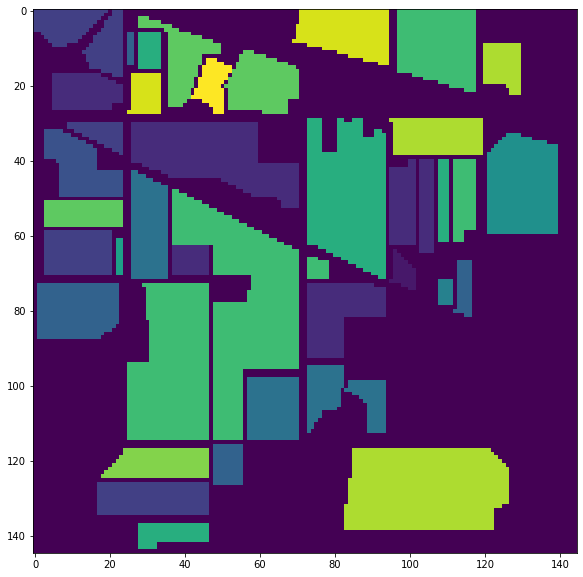

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(arr_pines_gt, cmap="viridis")

In [5]:
labels = ["Unknown", "Alfalfa", "Corn-notill", "Corn-mintill", "Corn", "Grass-pasture", "Grass-trees", 
          "Grass-pasture-mowed", "Hay-windrowed", "Oats", "Soybean-notill", "Soybean-mintill", "Soybean-clean",
          "Wheat", "Woods", "Building-Grass-Tree-Drives", "Stone-Steel-Towers"]
labels

['Unknown',
 'Alfalfa',
 'Corn-notill',
 'Corn-mintill',
 'Corn',
 'Grass-pasture',
 'Grass-trees',
 'Grass-pasture-mowed',
 'Hay-windrowed',
 'Oats',
 'Soybean-notill',
 'Soybean-mintill',
 'Soybean-clean',
 'Wheat',
 'Woods',
 'Building-Grass-Tree-Drives',
 'Stone-Steel-Towers']

(9604, 955)

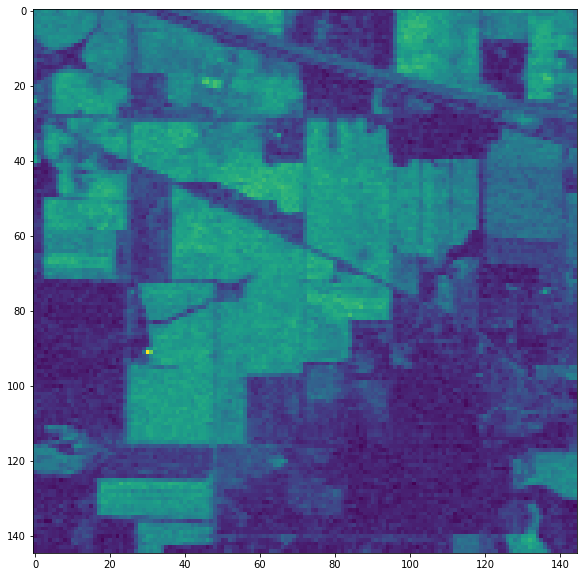

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(arr_pines[:,:,150])
arr_pines.max(), arr_pines.min()

In [7]:
def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

In [8]:
print("arr_pines has", arr_pines.shape[2], "dim")
arr_pines.min(), arr_pines.max()

arr_pines has 200 dim


(955, 9604)

Les images ont été récupérées avec un capteur faisant du : 400 μm (visible/bleu) jusqu'à 2500 μm (proche infrarouge), avec une largeur de bande de 10 nm.
Wikipedia donne :
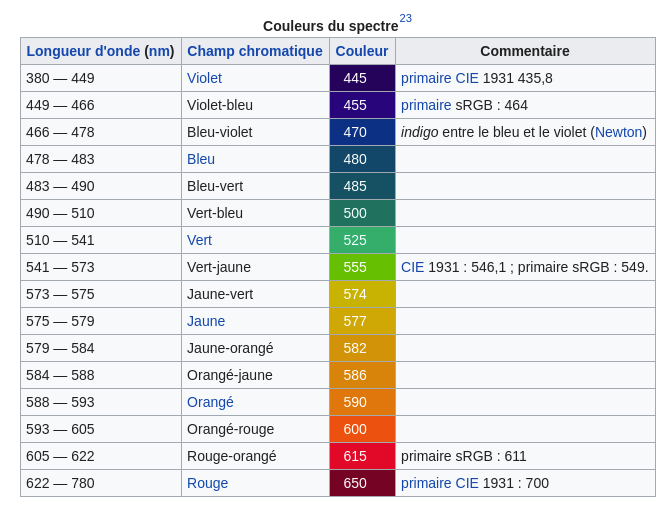

Il faut donc récupérer les longeurs d'ondes 464; 549 et 611 si l'on souhaite reconstruire l'image en RGB.

$$
\begin{align}
400 + 10 \times i &= \lambda\\
i &= \frac{\lambda - 400}{10}
\end{align}
$$

In [9]:
def find_index_wavelength(lambda_wl):
    return round((lambda_wl - 400) / 10)

In [10]:
r = find_index_wavelength(611)
g = find_index_wavelength(549)
b = find_index_wavelength(464)
rgb_pines = arr_pines[:,:,[r, g, b]]

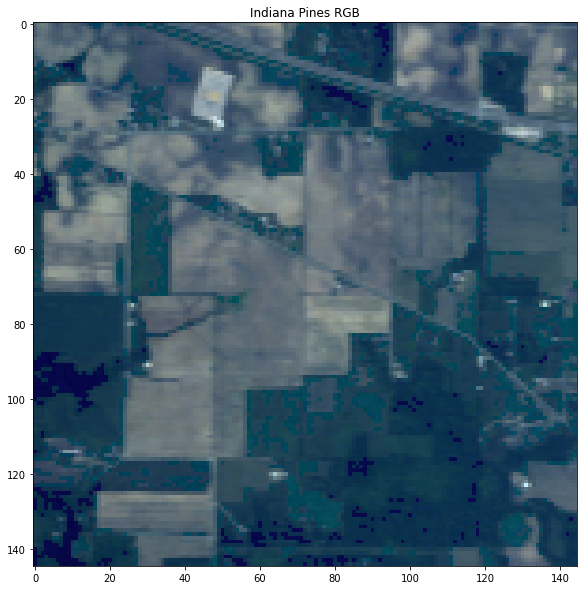

In [11]:
plt.figure(figsize=(10,10))
plt.title("Indiana Pines RGB")
plt.imshow(normalize(rgb_pines))
row,col,dim = arr_pines.shape

## Creation of train, test sets
We will first retrieve all the hyperspectral pixels and sort them according to their given class

In [12]:
from sklearn.model_selection import train_test_split
X = arr_pines.reshape((-1, dim))
y = arr_pines_gt.reshape((-1))
# X = arr_pines.copy()
# y = arr_pines_gt.copy()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
X_test.shape

(6308, 200)

In [15]:
np.round(np.unique(y_train, return_counts=True)[1] / (y_train.shape[0]) * 100)

array([51.,  0.,  7.,  4.,  1.,  2.,  3.,  0.,  2.,  0.,  5., 12.,  3.,
        1.,  6.,  2.,  0.])

In [16]:
np.round(np.unique(y_test, return_counts=True)[1] / (y_test.shape[0]) * 100)

array([52.,  0.,  7.,  3.,  1.,  2.,  4.,  0.,  2.,  0.,  5., 12.,  3.,
        1.,  6.,  2.,  0.])

In [17]:
X_train.shape

(14717, 200)

In [18]:
nb_comp = 10

In [19]:
from sklearn import decomposition
def reduc_dim(X, nb_comp):
    pca = sklearn.decomposition.PCA()
    pca.fit(X)
    return pca.transform(X)[:,:nb_comp], pca

## With `DecisionTreeClassifier`

In [20]:
X_train, pca = reduc_dim(X_train, nb_comp)
X_test, pca_test = reduc_dim(X_test, nb_comp)

In [21]:
X_test.shape, y_test.shape

((6308, 10), (6308,))

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
dtc = DecisionTreeClassifier()
clf = GridSearchCV(dtc, {'criterion':("gini", "entropy"), 'splitter':(['best','random'])}, refit=True)
clf.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'splitter': ['best', 'random']})

In [23]:
from sklearn.metrics import plot_confusion_matrix, classification_report

              precision    recall  f1-score   support

           0       0.79      0.66      0.71      3927
           1       0.50      0.62      0.55        13
           2       0.22      0.23      0.22       398
           3       0.34      0.29      0.31       251
           4       0.14      0.18      0.16        61
           5       0.14      0.07      0.09       232
           6       0.00      0.02      0.01        45
           7       0.09      0.09      0.09        11
           8       0.58      0.69      0.63       123
           9       0.20      0.05      0.07        22
          10       0.47      0.46      0.46       301
          11       0.40      0.47      0.44       627
          12       0.11      0.24      0.15        86
          13       0.00      0.00      0.00         2
          14       0.05      0.26      0.09        80
          15       0.04      0.04      0.04        89
          16       0.90      0.45      0.60        40

    accuracy              

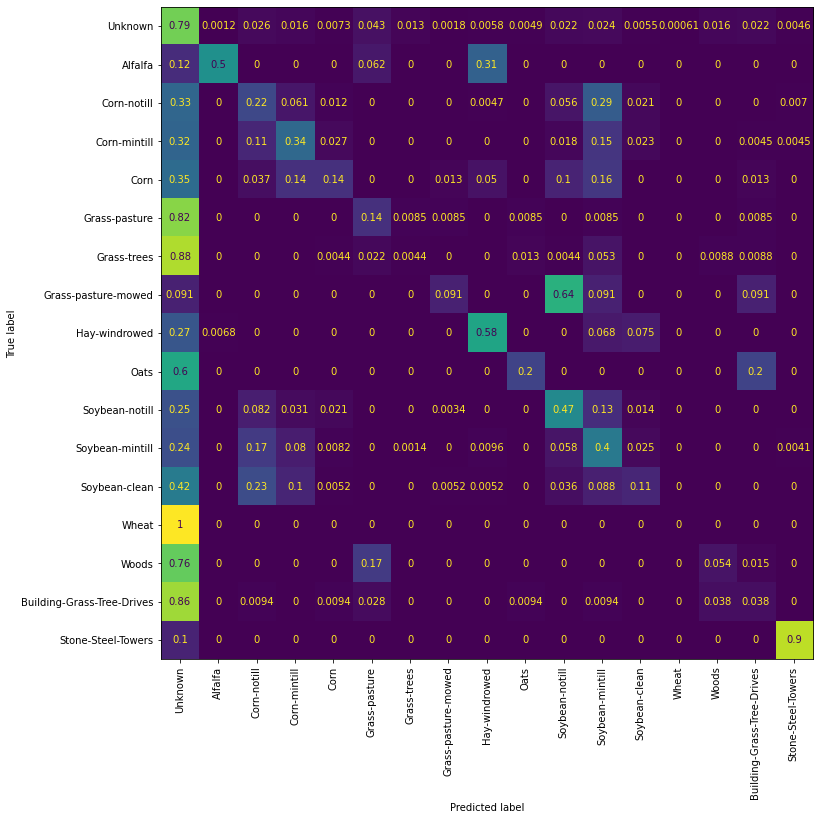

In [24]:
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(clf, X_test, y_test, ax=ax, display_labels=labels,
                      xticks_rotation="vertical",normalize="true",
                     colorbar=False)
y_predicted = clf.predict(X_test)
# round(len(np.where(y_predicted == y_test)[0]) / len(y_test) * 100, 2)
print(classification_report(y_predicted, y_test))

In [25]:
clf.get_params()

{'cv': None,
 'error_score': nan,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__random_state': None,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeClassifier(),
 'n_jobs': None,
 'param_grid': {'criterion': ('gini', 'entropy'),
  'splitter': ['best', 'random']},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [26]:
clf.cv_results_['mean_test_score']

array([0.65067655, 0.63389267, 0.65828488, 0.64197774])

In [27]:
clf.best_estimator_, clf.best_score_

(DecisionTreeClassifier(criterion='entropy'), 0.6582848810368006)

# With Nearest Neighbours classifier

In [28]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier()
clf = GridSearchCV(knc, {'n_neighbors':(2, 3, 4, 5, 6, 7)}, refit=True)
clf.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': (2, 3, 4, 5, 6, 7)})

/home/ajix/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ajix/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ajix/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.88      0.65      0.74      4446
           1       0.31      0.83      0.45         6
           2       0.18      0.28      0.22       271
           3       0.41      0.34      0.38       264
           4       0.00      0.00      0.00       117
           5       0.01      0.02      0.01        64
           6       0.00      0.00      0.00        31
           7       0.00      0.00      0.00         0
           8       0.25      0.79      0.38        47
           9       0.00      0.00      0.00         0
          10       0.50      0.27      0.35       532
          11       0.25      0.44      0.32       416
          12       0.04      0.21      0.07        38
          13       0.00      0.00      0.00         0
          14       0.03      0.22      0.05        45
          15       0.01      0.20      0.02         5
          16       0.65      0.50      0.57        26

    accuracy              

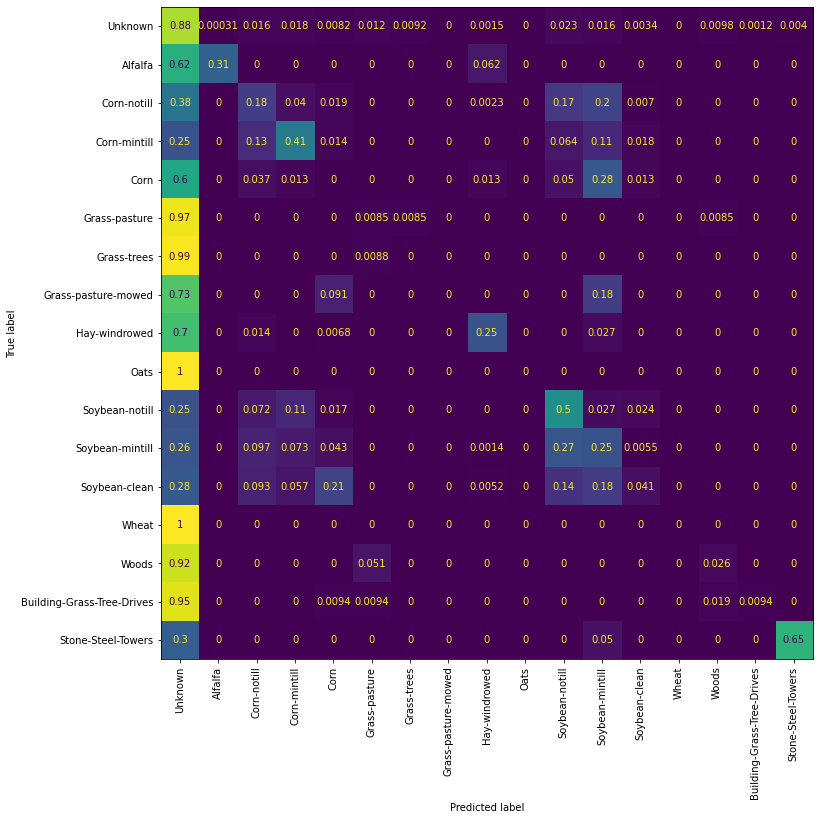

In [29]:
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(clf, X_test, y_test, ax=ax, display_labels=labels,
                      xticks_rotation="vertical",normalize="true",
                     colorbar=False)
y_predicted = clf.predict(X_test)
# round(len(np.where(y_predicted == y_test)[0]) / len(y_test) * 100, 2)
print(classification_report(y_predicted, y_test))

In [30]:
clf.cv_results_['mean_test_score']

array([0.67839921, 0.69429881, 0.70109363, 0.70483062, 0.70387997,
       0.70469558])

In [31]:
clf.best_estimator_, clf.best_score_

(KNeighborsClassifier(), 0.70483061778871)

le score moyen est étonnamment bon mais le modèle ne reconnait pas du tout l'avoine

# With SVC

In [32]:
from sklearn.svm import SVC
svc = SVC()

In [33]:
clf = GridSearchCV(svc, {'C':[1], 'kernel':['linear', 'poly', 'rbf', 'sigmoid']}, refit=)

In [34]:
clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             refit=False)

NotFittedError: This GridSearchCV instance was initialized with refit=False. predict is available only after refitting on the best parameters. You can refit an estimator manually using the ``best_params_`` attribute

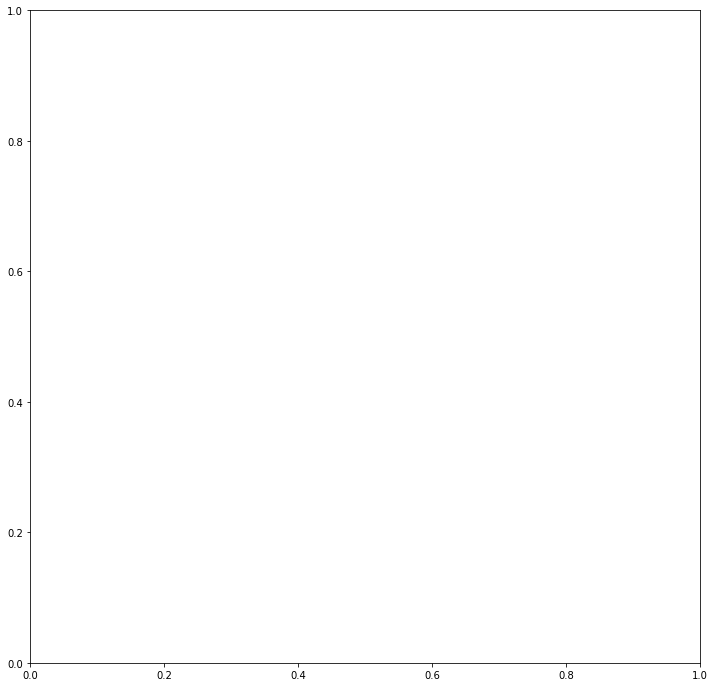

In [35]:
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(clf, X_test, y_test, ax=ax, display_labels=labels,
                      xticks_rotation="vertical",normalize="true",
                     colorbar=False)
y_predicted = clf.predict(X_test)
# round(len(np.where(y_predicted == y_test)[0]) / len(y_test) * 100, 2)
print(classification_report(y_predicted, y_test))

In [ ]:
clf.cv_results_['mean_test_score']

In [ ]:
clf.best_estimator_, clf.best_score_